<a href="https://colab.research.google.com/github/RishabhQuantum/Nuclear-Dynamics/blob/Nuclear-Nuclear-Entanglement/Nuclear_Entanglement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 38.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import physical_constants
from qutip import (Qobj,qeye,sigmax,sigmay,sigmaz,singlet_state,triplet_states,tensor,mesolve,negativity,partial_transpose,entropy)

In [3]:
# Horodecki criterion for Bell violation
# ref: https://doi.org/10.1016/0375-9601(95)00214-N
def horodecki_criterion(rho):

# correlation matrix T
  T = np.zeros((3, 3))
  pauli = [sigmax(), sigmay(), sigmaz()]

  for i in range(3):
    for j in range(3):
      T[i, j] = (tensor(pauli[i], pauli[j])*rho).tr().real

# eigenvalues of T^T T in ascending order
  s = np.linalg.eigvals(T.transpose()*T)

  return s[1]**2 + s[2]**2 # Bell violation if  >1

In [4]:
sx = 0.5*sigmax()
sy = 0.5*sigmay()
sz = 0.5*sigmaz()

In [5]:
# spin relaxation
kra = 1e6
krb = 1e6

c_ops = [
    np.sqrt(kra) * tensor(sx,qeye(2),qeye(2),qeye(2)),
    np.sqrt(kra) * tensor(sy,qeye(2),qeye(2),qeye(2)),
    np.sqrt(kra) * tensor(sz,qeye(2),qeye(2),qeye(2)),
    np.sqrt(krb) * tensor(qeye(2),sx,qeye(2),qeye(2)),
    np.sqrt(krb) * tensor(qeye(2),sy,qeye(2),qeye(2)),
    np.sqrt(krb) * tensor(qeye(2),sz,qeye(2),qeye(2)),
]

In [6]:
# physical constants
hbar = physical_constants['Planck constant over 2 pi'][0]
g_e = physical_constants['electron g factor'][0]
mu_B = physical_constants['Bohr magneton'][0]
g_n = physical_constants['proton g factor'][0] # proton g-factor
mu_n = physical_constants['nuclear magneton'][0]
gammae = (mu_B*g_e)/(hbar*1000) # 1/(mT*s)
gamman = (mu_n*g_n)/(hbar*1000) # 1/(mT*s) # gyromagnetic ration for proton

In [7]:
#interaction strengths
B = 0.05*gammae # 0.05 mT - geomagnetic field
Bn = B*gamman/gammae
a = 10*gammae # 10 mT - same isotropic HFCC for both nuclei
J = -0.0035*gammae # -0.0035 mT - exchange and dipole values taken to be similar to cry4 case: https://doi.org/10.1038/s41586-021-03618-9
D = 1.85*gammae/(2**3) # 2 nm

In [8]:
# initial state - singlet state for elctrons, completely mixed for nuclei
# electronA ⊗ electronB ⊗ NucleusA ⊗ NucleusB
# Both nuclear spins are spin-1/2 (hydrogen - 1)
rhoi=tensor(singlet_state()*singlet_state().dag(),0.5*qeye(2),0.5*qeye(2))

In [9]:
# Hamiltonian
DipoleZ = D*(tensor(sx,sx,qeye(2),qeye(2))+tensor(sy,sy,qeye(2),qeye(2))-2*tensor(sz,sz,qeye(2),qeye(2)))
Exchange = J*(tensor(sx,sx,qeye(2),qeye(2))+tensor(sy,sy,qeye(2),qeye(2))+tensor(sz,sz,qeye(2),qeye(2)))
Zeeman_A = -B*tensor(sz,qeye(2),qeye(2),qeye(2))
Zeeman_B = -B*tensor(qeye(2),sz,qeye(2),qeye(2))
Zeeman_n_A = Bn*tensor(qeye(2),qeye(2),sz,qeye(2))
Zeeman_n_B = Bn*tensor(qeye(2),qeye(2),qeye(2),sz)
HFI_A = a*(tensor(sx,qeye(2),sx,qeye(2))+tensor(sy,qeye(2),sy,qeye(2))+tensor(sz,qeye(2),sz,qeye(2)))
HFI_B = a*(tensor(qeye(2),sx,qeye(2),sx)+tensor(qeye(2),sy,qeye(2),sy)+tensor(qeye(2),sz,qeye(2),sz))
Ham = DipoleZ + Exchange +Zeeman_A + Zeeman_B + HFI_A + HFI_B + Zeeman_n_A + Zeeman_n_B

In [10]:
# time evolution
tlist = np.linspace(0, 2.0e-6,2000)
rhot = mesolve(Ham, rhoi, tlist,c_ops=c_ops)
# partial density matrices
rhot_e = [rho.ptrace([0, 1]) for rho in rhot.states]
rhot_n = [rho.ptrace([2, 3]) for rho in rhot.states]
# purity
purity_e = [(rho**2).tr() for rho in rhot_e]
purity_n = [(rho**2).tr() for rho in rhot_n]
#logarithmic negetivity
negativity_e = [negativity(rho,0,logarithmic=True,method='tracenorm') for rho in rhot_e]
negativity_n = [negativity(rho,0,logarithmic=True,method='tracenorm') for rho in rhot_n]
#Horodecki criterion
horodecki_e = [horodecki_criterion(rho) for rho in rhot_e]
horodecki_n = [horodecki_criterion(rho) for rho in rhot_n]

In [11]:
# projecting the electronic subsystem to singlet subspace
# total density matix post measurement
rhot_pm = [((4*rhoi).dag()*rho*(4*rhoi)/((4*rhoi*rho).tr())) for rho in rhot.states]
# partial density matrices
rhot_pm_e = [rho.ptrace([0, 1]) for rho in rhot_pm]
rhot_pm_n = [rho.ptrace([2, 3]) for rho in rhot_pm]
# purity
purity_pm_e = [(rho**2).tr() for rho in rhot_pm_e]
purity_pm_n = [(rho**2).tr() for rho in rhot_pm_n]
#logarithmic negetivity
negativity_pm_e = [negativity(rho,0,logarithmic=True,method='tracenorm') for rho in rhot_pm_e]
negativity_pm_n = [negativity(rho,0,logarithmic=True,method='tracenorm') for rho in rhot_pm_n]
#Horodecki criterion
horodecki_pm_e = [horodecki_criterion(rho) for rho in rhot_pm_e]
horodecki_pm_n = [horodecki_criterion(rho) for rho in rhot_pm_n]

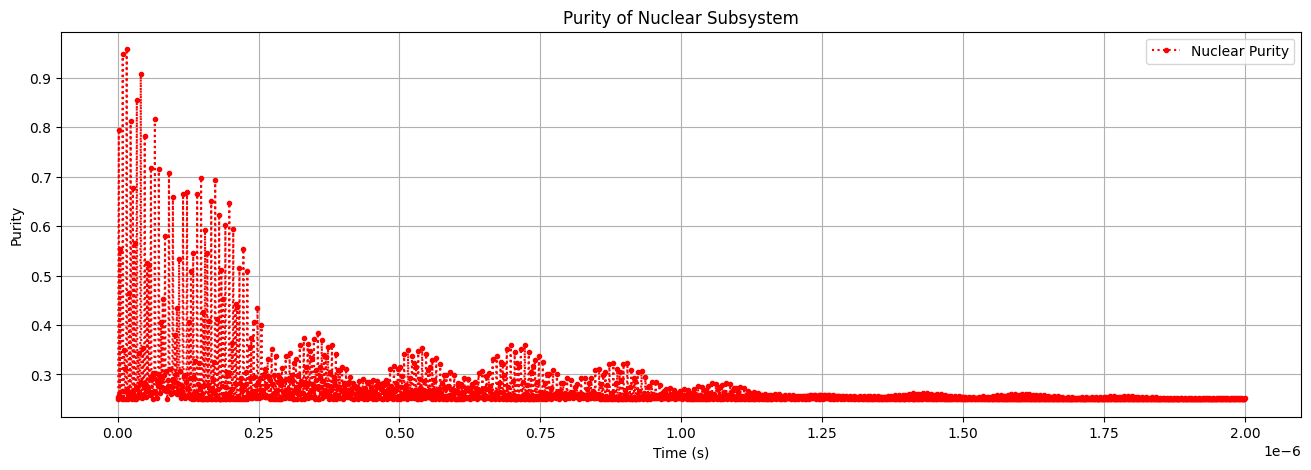

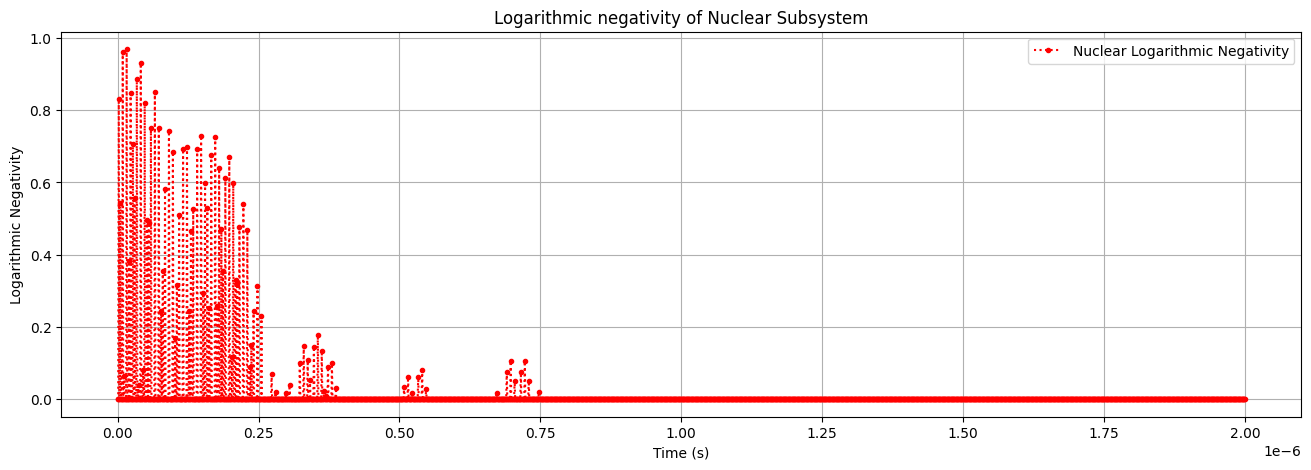

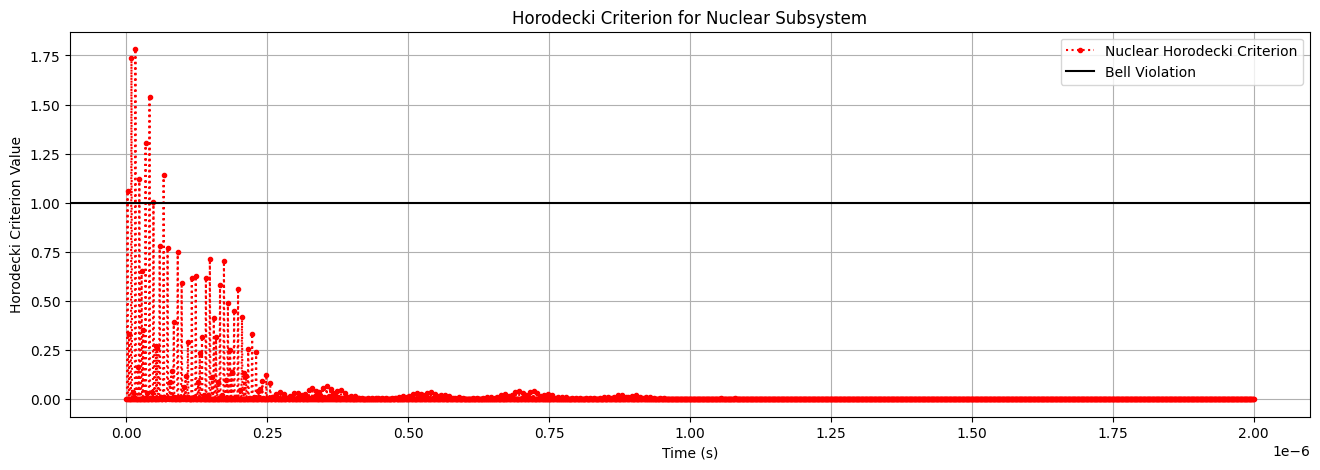

In [12]:
# post projection plots

# nuclear purity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, purity_pm_n, label='Nuclear Purity',linestyle=':', marker = '.',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Purity')
plt.title('Purity of Nuclear Subsystem')
plt.grid(True)
plt.legend()
plt.show()

# Nuclear logarithmic negativity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, negativity_pm_n, label='Nuclear Logarithmic Negativity',linestyle=':', marker = '.',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Logarithmic Negativity')
plt.title('Logarithmic negativity of Nuclear Subsystem')
plt.grid(True)
plt.legend()
plt.show()

# Horodecki criterion for the nuclear subsystem
plt.figure(figsize=(16, 5))
plt.plot(tlist, horodecki_pm_n, label='Nuclear Horodecki Criterion', linestyle=':', marker='.', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Horodecki Criterion Value')
plt.axhline(y=1, color='black', linestyle='-', label='Bell Violation')
plt.title('Horodecki Criterion for Nuclear Subsystem')
plt.grid(True)
plt.legend()
plt.show()

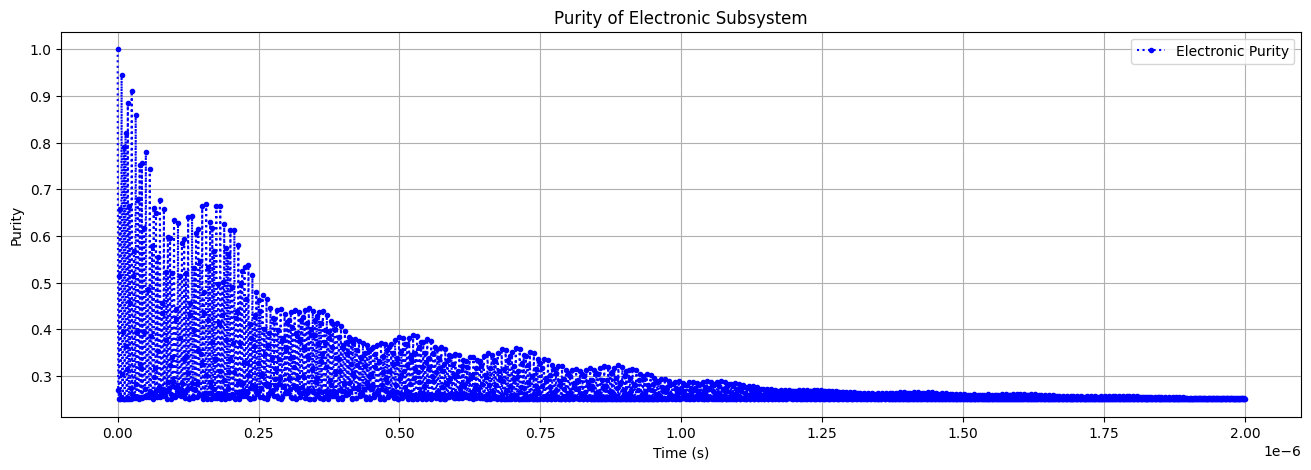

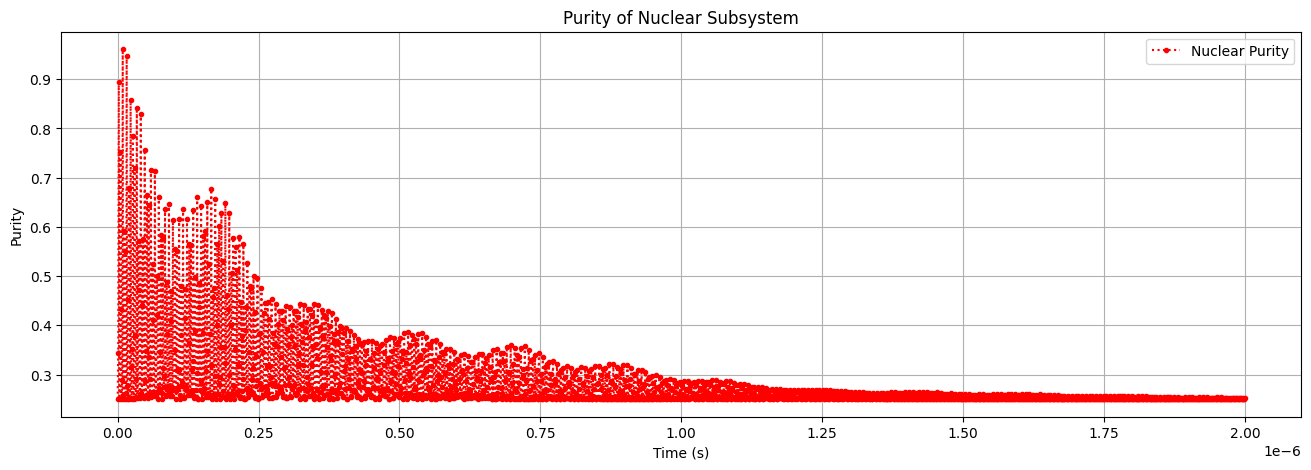

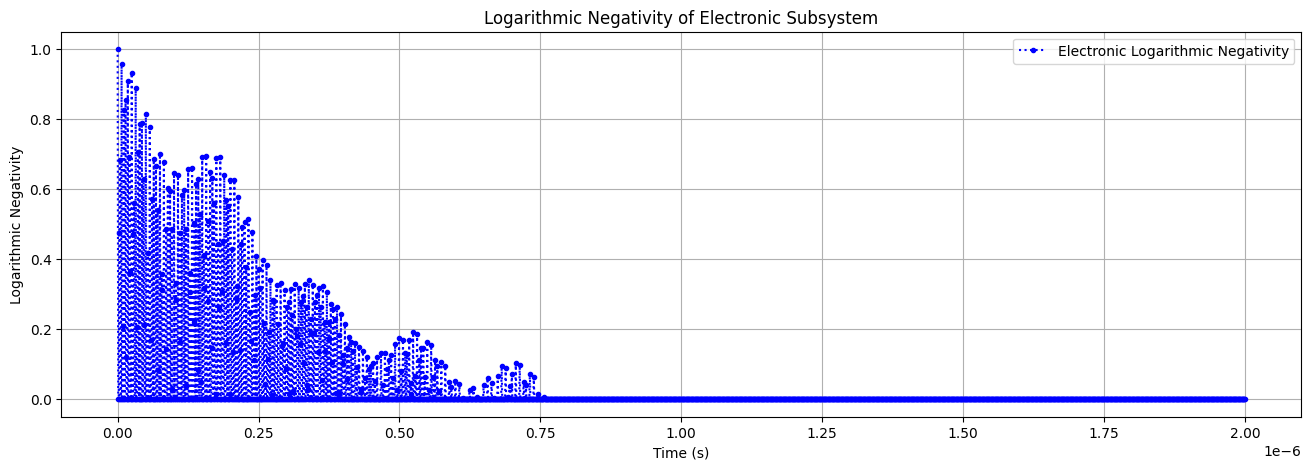

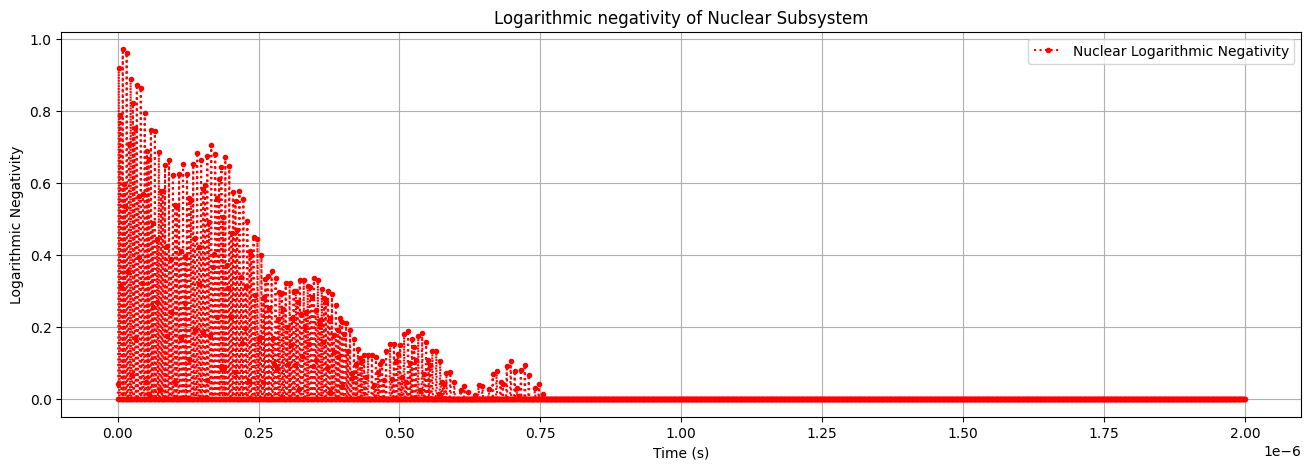

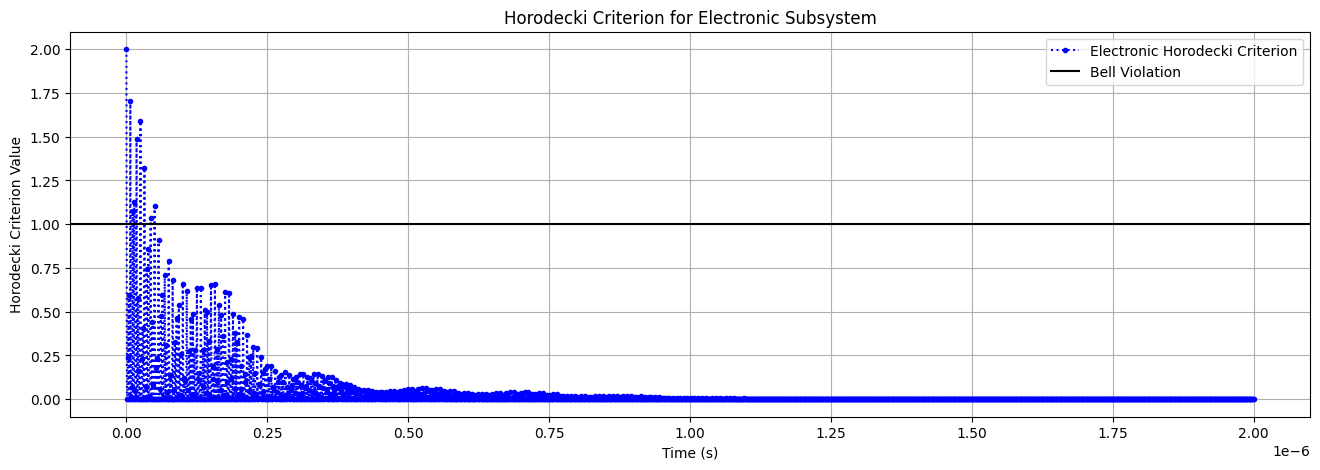

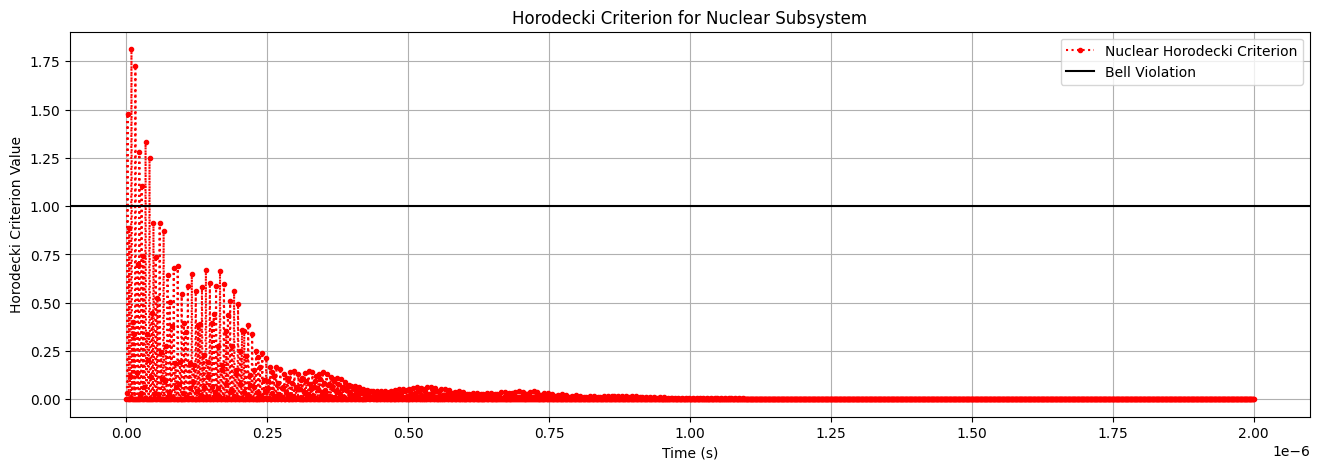

In [13]:
# No projection

# electronic purity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, purity_e, label='Electronic Purity',linestyle=':', marker = '.',color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Purity')
plt.title('Purity of Electronic Subsystem')
plt.grid(True)
plt.legend()
plt.show()

# nuclear purity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, purity_n, label='Nuclear Purity',linestyle=':', marker = '.',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Purity')
plt.title('Purity of Nuclear Subsystem')
plt.grid(True)
plt.legend()
plt.show()


# electronic logarithmic negativity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, negativity_e, label='Electronic Logarithmic Negativity',linestyle=':', marker = '.',color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Logarithmic Negativity')
plt.title('Logarithmic Negativity of Electronic Subsystem')
plt.grid(True)
plt.legend()
plt.show()

# Nuclear logarithmic negativity plot
plt.figure(figsize=(16, 5))
plt.plot(tlist, negativity_n, label='Nuclear Logarithmic Negativity',linestyle=':', marker = '.',color='red')
plt.xlabel('Time (s)')
plt.ylabel('Logarithmic Negativity')
plt.title('Logarithmic negativity of Nuclear Subsystem')
plt.grid(True)
plt.legend()
plt.show()

# Horodecki criterion for the electronic subsystem
plt.figure(figsize=(16, 5))
plt.plot(tlist, horodecki_e, label='Electronic Horodecki Criterion', linestyle=':', marker='.', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Horodecki Criterion Value')
plt.axhline(y=1, color='black', linestyle='-', label='Bell Violation') # Highlight Bell violation
plt.title('Horodecki Criterion for Electronic Subsystem')
plt.grid(True)
plt.legend()
plt.show()

# Horodecki criterion for the nuclear subsystem
plt.figure(figsize=(16, 5))
plt.plot(tlist, horodecki_n, label='Nuclear Horodecki Criterion', linestyle=':', marker='.', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Horodecki Criterion Value')
plt.axhline(y=1, color='black', linestyle='-', label='Bell Violation')
plt.title('Horodecki Criterion for Nuclear Subsystem')
plt.grid(True)
plt.legend()
plt.show()